# Music & Mental Health: How Does Music Influence Psychological Well-being?

This project explores the relationship between music preferences and mental health indicators across different age groups. It aims to understand how various music genres may affect conditions such as anxiety, depression, insomnia, and obsessive-compulsive disorder (OCD).

The data originates from a survey in which respondents reported:
- Their age
- Favorite music genre
- Self-rated mental health levels
- Whether they feel music improved, worsened, or had no effect on their mental state

###  Key Research Questions:
- Which music genres are most effective in reducing symptoms of mental health conditions?
- How do these effects vary across age groups?
- Are subjective perceptions of music's effect aligned with actual mental health levels?


## Dataset Description

**Dataset Source**

This dataset was imported directly from Kaggle:

**"Music & Mental Health Survey"**  
https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results

It includes over 600 responses with information about music habits and mental health indicators.

The dataset is based on survey responses and contains the following key fields:

- `age`: Respondent's age (numeric)
- `fav_genre`: Favorite music genre
- `bpm`: Preferred beats per minute (tempo)
- `anxiety`, `depression`, `insomnia`, `ocd`: Self-rated mental health indicators on a numeric scale
- `music_effects`: Respondent's perception of how music impacts their mental health (improves / worsens / no effect)

---
### Preprocessing Steps:
- Categorical responses in `music_effects` were mapped to numerical values:  
  - `improves` → 1  
  - `no effect` and missing (`NaN`) → 0  
  - `worsens` → -1
- Age groups were created using conditional logic to segment respondents into:
  - Teenagers (11–20), Young Adults (21–30), Adults (31+)
- Missing values in mental health indicators were filled with 0 where appropriate to allow numerical analysis.
- SQL queries (DuckDB) were used to group, rank, and aggregate genre-specific effects per age group.

The dataset was analyzed using a combination of SQL, Pandas, and Seaborn/Matplotlib for visualization.


In [1]:
# 1. Install kagglehub (if needed)
# !pip install -q kagglehub

# 2. Import the library
import kagglehub

# 3. Download the dataset
path = kagglehub.dataset_download("catherinerasgaitis/mxmh-survey-results")

# 4. Check what files are there
import os
os.listdir(path)

/Users/vighzoltan/miniconda3/envs/dataproj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['mxmh_survey_results.csv']

In [2]:
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(os.path.join(path, "mxmh_survey_results.csv"))
df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [4]:
df.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions'],
      dtype='object')

In [5]:
df.columns = (df.columns.str.lower().str.replace(' ','_').str.replace('[','').str.replace(']',''))
df.columns

Index(['timestamp', 'age', 'primary_streaming_service', 'hours_per_day',
       'while_working', 'instrumentalist', 'composer', 'fav_genre',
       'exploratory', 'foreign_languages', 'bpm', 'frequency_classical',
       'frequency_country', 'frequency_edm', 'frequency_folk',
       'frequency_gospel', 'frequency_hip_hop', 'frequency_jazz',
       'frequency_k_pop', 'frequency_latin', 'frequency_lofi',
       'frequency_metal', 'frequency_pop', 'frequency_r&b', 'frequency_rap',
       'frequency_rock', 'frequency_video_game_music', 'anxiety', 'depression',
       'insomnia', 'ocd', 'music_effects', 'permissions'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   736 non-null    object 
 1   age                         735 non-null    float64
 2   primary_streaming_service   735 non-null    object 
 3   hours_per_day               736 non-null    float64
 4   while_working               733 non-null    object 
 5   instrumentalist             732 non-null    object 
 6   composer                    735 non-null    object 
 7   fav_genre                   736 non-null    object 
 8   exploratory                 736 non-null    object 
 9   foreign_languages           732 non-null    object 
 10  bpm                         629 non-null    float64
 11  frequency_classical         736 non-null    object 
 12  frequency_country           736 non-null    object 
 13  frequency_edm               736 non

I've normalized the column headers:
- removed the spaces and replaced with `_`
- removed the `[]`
- made all lowercase

After checking the values we can be sure there are no NULL/NaN values so the data considered as clean for now at least. 

For the analysis I'm planning to use DuckDB which is imported on the top. DuckDB library can be used to execute SQL commands and handles Pandas DataFrame as if it was a DataBase. 

# Get us familiar with the data we use

We are interested in the below fields of the dataset:
- age
- fav_genre
- bpm
- anxiety
- depression
- insomnia
- ocd
- music_effects

Now, as we've determined what columns we need for our analysis let's make a sub-df for only these

In [7]:
final_df = df[['age','fav_genre','bpm','anxiety','depression','insomnia','ocd','music_effects']]
final_df.head()

,age,fav_genre,bpm,anxiety,depression,insomnia,ocd,music_effects
0,18.0,Latin,156.0,3.0,0.0,1.0,0.0,NaN
1,63.0,Rock,119.0,7.0,2.0,2.0,1.0,NaN
2,18.0,Video game music,132.0,7.0,7.0,10.0,2.0,No effect
3,61.0,Jazz,84.0,9.0,7.0,3.0,3.0,Improve
4,18.0,R&B,107.0,7.0,2.0,5.0,9.0,Improve


In [8]:
effect_map = {
    'no effect': 0,
    'improve': 1,
    'worsen': -1
}

final_df['music_effects'] = (final_df['music_effects'].str.lower().fillna('no effect').map(effect_map))
final_df.head()

/var/folders/pv/0r6144t527l1c16qwclpvwvw0000gn/T/ipykernel_30536/4076899543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['music_effects'] = (final_df['music_effects'].str.lower().fillna('no effect').map(effect_map))


,age,fav_genre,bpm,anxiety,depression,insomnia,ocd,music_effects
0,18.0,Latin,156.0,3.0,0.0,1.0,0.0,0
1,63.0,Rock,119.0,7.0,2.0,2.0,1.0,0
2,18.0,Video game music,132.0,7.0,7.0,10.0,2.0,0
3,61.0,Jazz,84.0,9.0,7.0,3.0,3.0,1
4,18.0,R&B,107.0,7.0,2.0,5.0,9.0,1


## Data Cleaning: Music Effects Column

To analyze the effects of music on mental health, we needed to convert the textual responses in the `music_effects` column into numerical values.

We used the following mapping:
- 'improves' → 1
- 'no effect' (and missing) → 0
- 'worsens' → -1

Missing values (`NaN`) were treated as 'no effect' to ensure consistency.

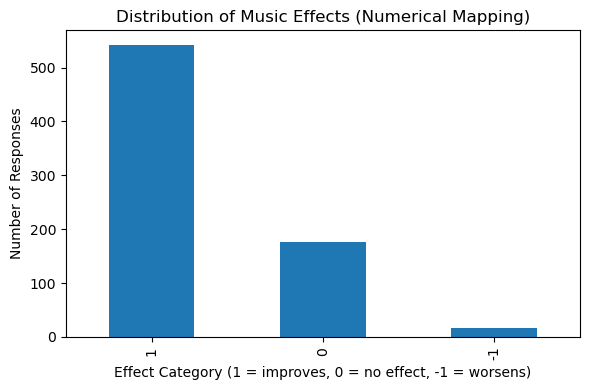

In [9]:
# Plot the distribution of the mapped values
final_df['music_effects'].value_counts().plot(kind='bar', figsize=(6, 4))
plt.title("Distribution of Music Effects (Numerical Mapping)")
plt.xlabel("Effect Category (1 = improves, 0 = no effect, -1 = worsens)")
plt.ylabel("Number of Responses")
plt.tight_layout()
plt.show()

## Data Type Adjustment

Some of the numerical columns in the dataset (`age`, `bpm`, and mental health scores) were originally in float format, even though they only contain whole numbers (e.g., 7.0, 0.0). 

To make the dataset cleaner and easier to work with, we:
- Filled any missing values with 0
- Converted these float columns to integers

This helps ensure consistency and prepares the data for grouping and aggregation.


In [10]:
cols = ['age', 'bpm', 'anxiety','depression','insomnia','ocd']
final_df[cols] = final_df[cols].fillna(0)
final_df[cols] = final_df[cols].astype(int)
final_df.head()

/var/folders/pv/0r6144t527l1c16qwclpvwvw0000gn/T/ipykernel_30536/1476335480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[cols] = final_df[cols].fillna(0)
/var/folders/pv/0r6144t527l1c16qwclpvwvw0000gn/T/ipykernel_30536/1476335480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[cols] = final_df[cols].astype(int)


,age,fav_genre,bpm,anxiety,depression,insomnia,ocd,music_effects
0,18,Latin,156,3,0,1,0,0
1,63,Rock,119,7,2,2,1,0
2,18,Video game music,132,7,7,10,2,0
3,61,Jazz,84,9,7,3,3,1
4,18,R&B,107,7,2,5,9,1


## What are the most commonly preferred music genres?

Before diving into how music affects mental health, it's useful to see which genres are the most popular among respondents.

This query counts the number of entries per genre:


In [11]:
fav_genre = db.query('''
SELECT 
fav_genre,
COUNT(*) volume
FROM final_df
GROUP BY fav_genre
ORDER BY 2 DESC
''').to_df()
fav_genre

,fav_genre,volume
0,Rock,188
1,Pop,114
2,Metal,88
3,Classical,53
4,Video game music,44
5,EDM,37
6,Hip hop,35
7,R&B,35
8,Folk,30
9,K pop,26


Interpretation: This gives us an idea of which genres are most represented in the dataset. We'll use this later to narrow our analysis to the most common genres.

## How do the most common genres affect mental health (on average)?

Let's focus on four popular genres — Rock, Pop, Classical, and Metal — and analyze their average perceived effect on mental health.


In [12]:
most_common_genre_effect = db.query('''
SELECT
fav_genre,
AVG(music_effects) avg_effect
FROM final_df
WHERE LOWER(fav_genre) IN ('rock','pop','metal','classical')
GROUP BY fav_genre
ORDER BY 2 DESC
''').to_df()
most_common_genre_effect

,fav_genre,avg_effect
0,Metal,0.761364
1,Classical,0.716981
2,Pop,0.710526
3,Rock,0.632979


Interpretation: Although no genre has a guaranteed positive or negative effect, Metal appears to have the most positive average impact among these.

## What are the mental health stats of metal fans?

Since Metal scored highest in average perceived effect, let's examine the average mental health condition of respondents who prefer metal music.
 

In [13]:
metal_fans_condition = db.query('''
SELECT
ROUND(AVG(age),2) avg_age,
ROUND(AVG(anxiety),2) avg_anxiety_lvl,
ROUND(AVG(depression),2) avg_depression_lvl,
ROUND(AVG(insomnia),2) avg_insomnia_lvl,
ROUND(AVG(ocd),2) avg_ocd_lvl
FROM final_df
WHERE LOWER(fav_genre) = 'metal'
ORDER BY 1,2,3,4,5
''').to_df()
metal_fans_condition

,avg_age,avg_anxiety_lvl,avg_depression_lvl,avg_insomnia_lvl,avg_ocd_lvl
0,25.11,5.76,5.07,4.56,2.4


Interpretation: The average age of metal fans is around 25, and the most significant challenge they face is anxiety — suggesting that metal may be particularly helpful in coping with that.

We can see that the average age of metal fans is `25` years. As young adoults the hardest mental health issue they can cope with is anxiety. It means, if you are someone who's having axiety issues, you should give a shot for metal - might gonna help. 

But what about music effect in general in every age group? Let's find out

## How does music affect mental health across age groups?

We'll break the dataset into age groups and analyze the average values for each mental health metric, along with perceived music effect.


In [14]:
age_groups = db.query('''
SELECT
CASE 
    WHEN age BETWEEN 0 AND 10 THEN '0-10'
    WHEN age BETWEEN 11 AND 20 THEN '11-20'
    WHEN age BETWEEN 21 AND 30 THEN '21-30'
    WHEN age BETWEEN 31 AND 40 THEN '31-40'
    WHEN age BETWEEN 41 AND 50 THEN '41-50'
ELSE '50+'
END age_group,
fav_genre,
ROUND(AVG(anxiety),2) avg_anxiety_lvl,
ROUND(AVG(depression),2) avg_depression_lvl,
ROUND(AVG(insomnia),2) avg_insomnia_lvl,
ROUND(AVG(ocd),2) avg_ocd_lvl,
ROUND(AVG(music_effects), 2) avg_music_effects
FROM final_df
GROUP BY 1,2
ORDER BY 1,2

''').to_df()
age_groups

,age_group,fav_genre,avg_anxiety_lvl,avg_depression_lvl,avg_insomnia_lvl,avg_ocd_lvl,avg_music_effects
0,0-10,Hip hop,9.00,3.00,2.00,7.00,1.00
1,0-10,Pop,8.00,2.00,1.00,1.00,1.00
2,11-20,Classical,4.85,3.78,3.52,2.44,0.70
3,11-20,Country,5.73,4.00,2.55,3.64,0.73
4,11-20,EDM,5.55,4.95,4.70,3.80,0.95
5,11-20,Folk,7.57,4.71,2.29,2.14,1.00
6,11-20,Gospel,3.00,0.00,2.00,2.00,1.00
7,11-20,Hip hop,6.29,5.88,2.71,2.35,1.00
8,11-20,Jazz,5.13,3.63,4.63,3.13,1.00
9,11-20,K pop,6.18,4.05,3.09,2.27,0.77


Interpretation: Some age groups like 0–10 may not be reliable — we'll consolidate into broader categories like teenagers, young adults, and adults.

## Which genres have the most positive effect in each age group?

We rank music genres within each age group by average music effect, and select the top ones.


In [15]:
best_genre_for_ages = db.query(
    '''
   SELECT 
    CASE 
        WHEN age_group = '11-20' THEN 'teenagers'
        WHEN age_group = '21-30' THEN 'young_adults'
        ELSE 'adults'
    END AS ages,
    fav_genre,
    avg_anxiety_lvl,
    avg_depression_lvl,
    avg_insomnia_lvl,
    avg_ocd_lvl,
    avg_music_effects
FROM age_groups
QUALIFY RANK() OVER (PARTITION BY age_group ORDER BY avg_music_effects DESC) = 1
ORDER BY ages
    '''
).to_df()
best_genre_for_ages

,ages,fav_genre,avg_anxiety_lvl,avg_depression_lvl,avg_insomnia_lvl,avg_ocd_lvl,avg_music_effects
0,adults,Hip hop,9.00,3.00,2.00,7.00,1.0
1,adults,Pop,8.00,2.00,1.00,1.00,1.0
2,adults,Classical,4.67,6.33,5.00,2.67,1.0
3,adults,Country,5.00,1.00,1.00,1.00,1.0
4,adults,EDM,8.00,8.00,2.00,0.00,1.0
5,adults,Lofi,8.00,8.00,2.00,2.00,1.0
6,adults,Jazz,9.00,4.00,4.00,4.00,1.0
7,adults,Classical,3.00,1.60,4.00,1.00,1.0
8,adults,Country,8.00,5.00,6.00,1.00,1.0
9,adults,Gospel,5.20,3.20,6.00,0.00,1.0


Interpretation: This gives us one or more genres per age group that are most positively associated with improved mental health.

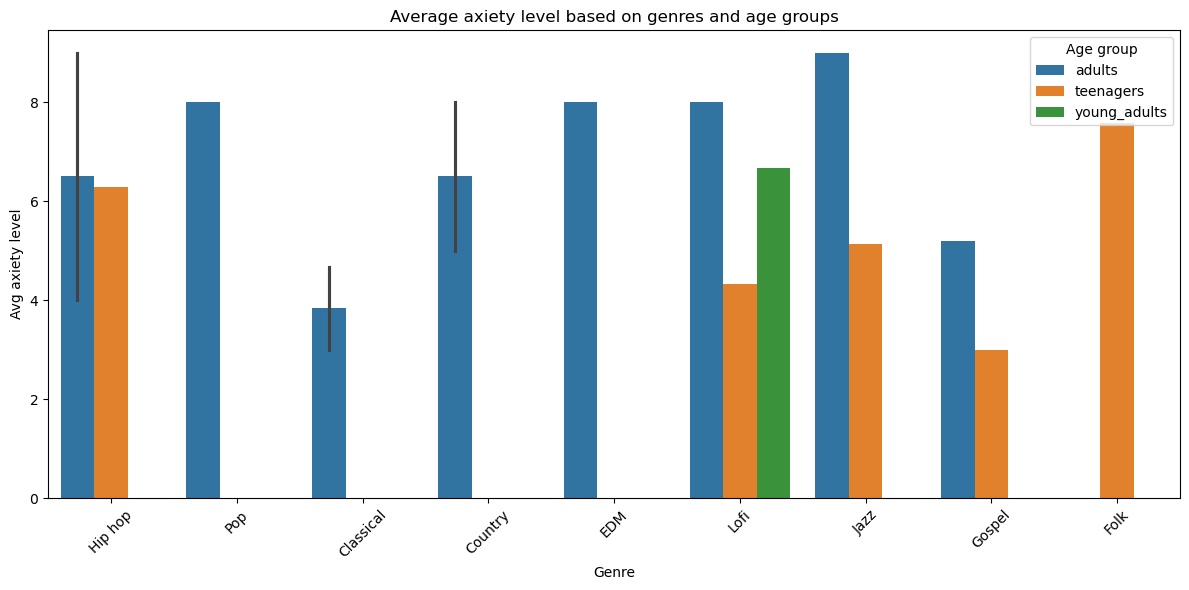

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=best_genre_for_ages, x='fav_genre', y='avg_anxiety_lvl', hue='ages')

plt.title('Average axiety level based on genres and age groups')
plt.xlabel('Genre')
plt.ylabel('Avg axiety level')
plt.legend(title='Age group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Heatmap: Mental Health Indicators by Music Genre

This heatmap shows how different music genres correlate with mental health indicators such as anxiety, depression, insomnia, and OCD. Each cell displays the average score for listeners of that genre.

Higher values may indicate more severe symptoms, while lower values suggest better mental well-being.


/var/folders/pv/0r6144t527l1c16qwclpvwvw0000gn/T/ipykernel_30536/2366464727.py:14: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/vighzoltan/miniconda3/envs/dataproj/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


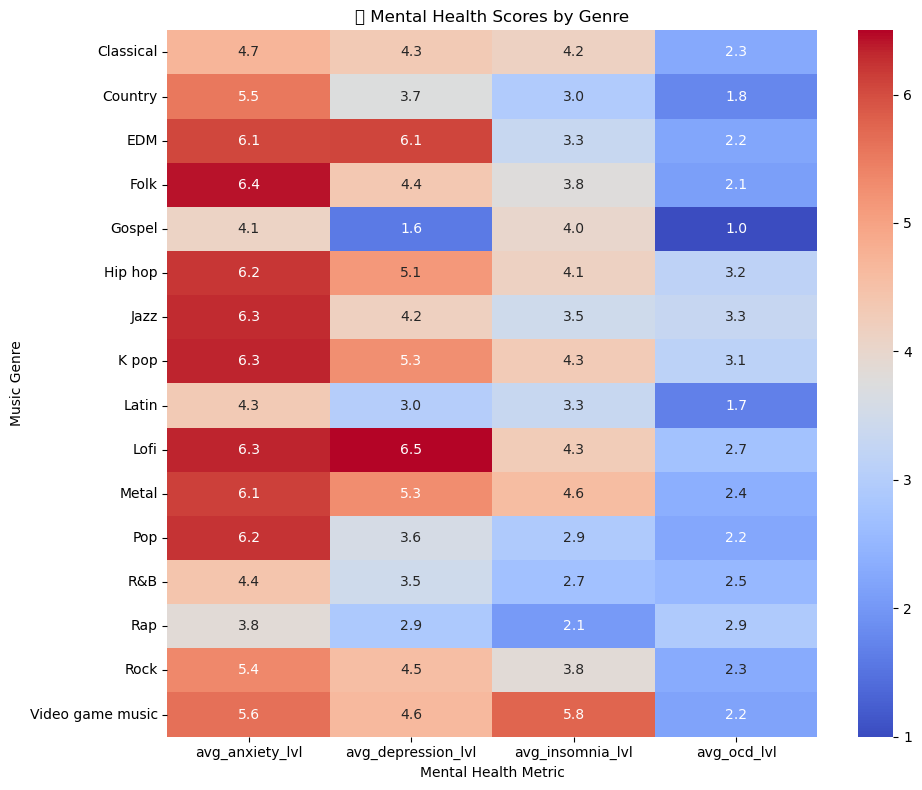

In [17]:
# Prepare pivot table
heatmap_data = age_groups.pivot_table(
    index='fav_genre',
    values=['avg_anxiety_lvl', 'avg_depression_lvl', 'avg_insomnia_lvl', 'avg_ocd_lvl'],
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("🧠 Mental Health Scores by Genre")
plt.ylabel("Music Genre")
plt.xlabel("Mental Health Metric")
plt.tight_layout()
plt.show()


## Radar Chart: Psychological Profile of Metal Fans

This radar chart represents the average mental health scores of respondents who prefer metal music. The closer the values are to the center, the lower (and generally better) the reported levels of mental health symptoms.


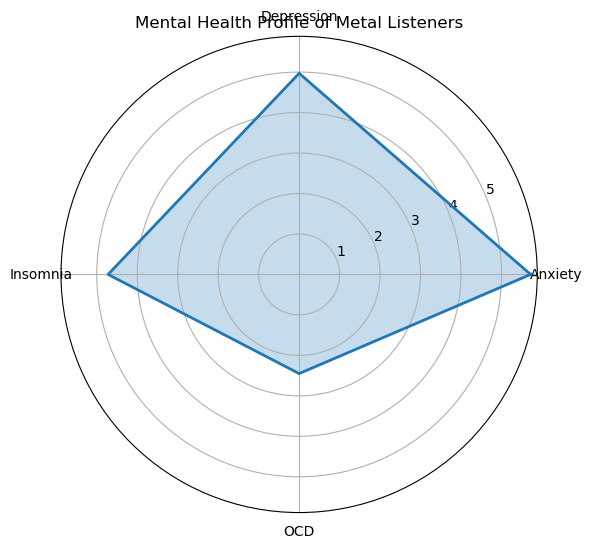

In [18]:
import numpy as np

# Select one genre: Metal
genre = 'Metal'
row = age_groups[age_groups['fav_genre'].str.lower() == genre.lower()].iloc[0]

# Define labels and values
labels = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
values = [
    row['avg_anxiety_lvl'],
    row['avg_depression_lvl'],
    row['avg_insomnia_lvl'],
    row['avg_ocd_lvl']
]
values += values[:1]  # close the radar circle

# Angles for the radar plot
angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)

# Create the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Mental Health Profile of {genre} Listeners")
plt.tight_layout()
plt.show()


## Bar Chart: Perceived Music Effect by Age Group and Genre

This grouped bar chart visualizes how different age groups perceive the mental effect of various music genres.

An average score of:
- 1 means the genre is generally perceived as improving mental health
- 0 means no effect
- -1 means worsening effect


/var/folders/pv/0r6144t527l1c16qwclpvwvw0000gn/T/ipykernel_30536/219412860.py:9: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/vighzoltan/miniconda3/envs/dataproj/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


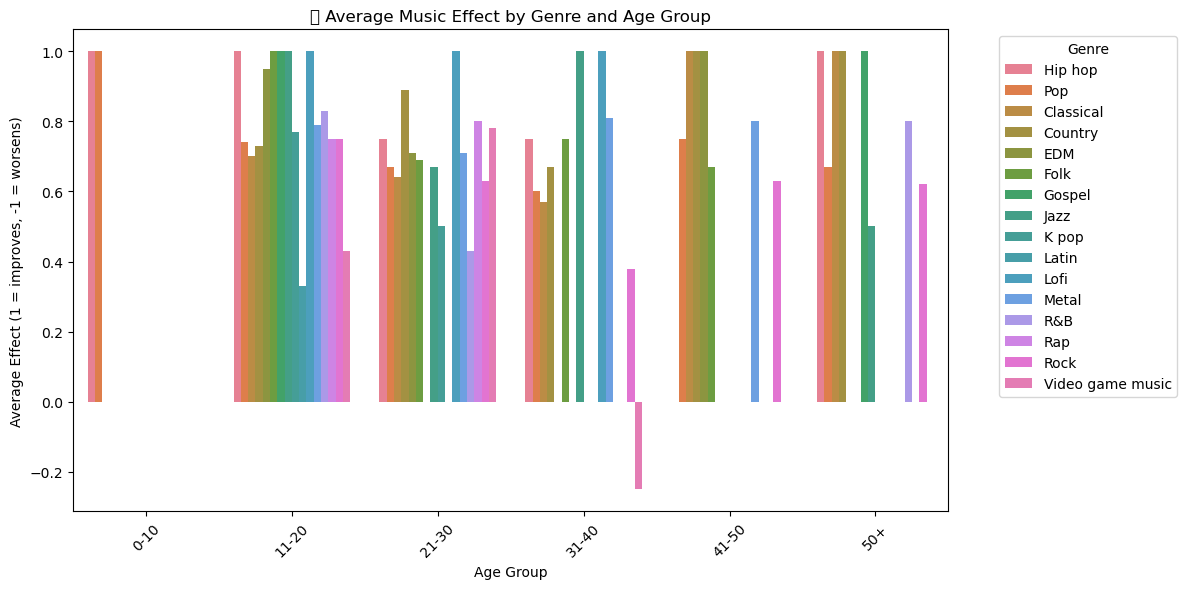

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(data=age_groups, x='age_group', y='avg_music_effects', hue='fav_genre')

plt.title("🎵 Average Music Effect by Genre and Age Group")
plt.ylabel("Average Effect (1 = improves, -1 = worsens)")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Line Chart: Music’s Perceived Effect by Age

This line plot shows how the average perceived effect of music on mental health changes with age.

It provides insight into whether older or younger people feel more positively (or negatively) about the influence of music.


/var/folders/pv/0r6144t527l1c16qwclpvwvw0000gn/T/ipykernel_30536/1315447714.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/vighzoltan/miniconda3/envs/dataproj/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


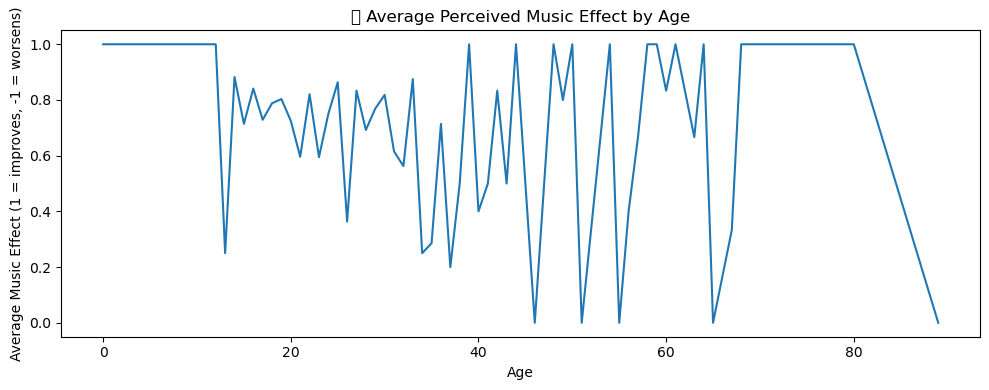

In [20]:
# Group by age to find average music effect
age_effect = final_df.groupby('age')['music_effects'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=age_effect, x='age', y='music_effects')
plt.title("📈 Average Perceived Music Effect by Age")
plt.ylabel("Average Music Effect (1 = improves, -1 = worsens)")
plt.xlabel("Age")
plt.tight_layout()
plt.show()

## Conclusion: What Did We Learn?

This project explored the relationship between music preferences and mental health, analyzing how different genres impact various psychological conditions across age groups.

### Key Takeaways:

- **Metal music** had the highest perceived positive effect on mental health among all genres in our dataset — especially helpful for younger adults dealing with anxiety.
- Among teenagers, genres like **lo-fi**, **gospel**, and **folk** showed positive mental associations, although their effects were less extreme than those observed for metal.
- Across all age groups, the average music effect score remained positive, suggesting that music — in general — tends to be perceived as beneficial.
- Mental health issues such as **anxiety** and **insomnia** showed genre-specific variation, indicating that some genres may align better with certain psychological needs.

### Limitations:

- The dataset is based on self-reported survey data, which may include subjective bias or inconsistency.
- Some age groups (e.g., under 10) were underrepresented or not meaningful in context.
- The mapping of textual responses to numerical scores, while practical, may simplify complex emotional experiences.

### Future Improvements:

- Use a larger or more balanced dataset to verify trends.
- Apply sentiment analysis or NLP on free-text responses (if available).
- Build a simple interactive app where users can explore results by age or genre (e.g., using Streamlit or Dash).

---

**Overall**, this analysis suggests that while music is not a substitute for professional care, it can play a supportive role in mental health — and some genres may resonate more strongly depending on age and psychological condition.
